En este notebook empleamos una estructura de circuito cuántico en la librería Pennylane para la clasificación de diferentes datasets. Entre ellos tenemos Iris y dos generados artificialmente. El primero de ellos es una dataset muy utilizado en ML, el segundo es un dataset que genera dos clases encerradas en círculos y el tercero es una dataset que genera dos clusters linealmente separables. La estructura de este circuito se obtuvo del tutorial en la página de Pennylane (https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) y esta inspirado en los papers de Fahri et al (https://arxiv.org/abs/1802.06002) y Schuld et al (https://arxiv.org/abs/1804.00633).

El paper lo dividiremos en tres partes, una por cada dataset. El circuito será el mismo pero estará adaptado a cada uno de los datasets a utilizar.

In [0]:
# importamos las librerías e instalamos aquellas que necesitemos
!pip install pennylane pennylane-sf pennylane-qiskit pennylane-cirq pennylane-forest pennylane-qsharp

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, NesterovMomentumOptimizer, GradientDescentOptimizer

In [0]:
import matplotlib.pyplot as plt

Definimos el modelo a utilizar

In [0]:
# declaramos el entorno en el cual se va a correr el circuito en dos qubits del simulador de pennylane
dev = qml.device("default.qubit", wires=2)

In [0]:
# función que ayuda a la codificación de los inputs en el circuito (estamos siguiendo aplitude codification)
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

# esta funcion nos ayuda a preparar el estado introducido, forma parte de la codificación por amplitud (protocolo muy utilizado en QML)
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

# arquitectura básica del circuito, en este caso recibirá dos parámetros (matriz de pesos) del dataset
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [0]:
# usamos el decorador para indicarle que es la funcion que compila el circuito (como vemos consta de la preparacion dle estado y luego aplica la capa tantas veces como filas tenga la matriz de pesos)
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

# en esta función cogemos los datos preprocesados por la funcion angles y alimentamos el circuito
def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias

# funcion coste, estamos utilizando el error cuadrático medio
def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

In [0]:
# funcion de coste
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
# funcion que nos da el accuracy
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# **Primera parte: dataset Iris**

Ahora cargamos los datos, como solo utilizaremos dos features para clasificar dos de las clases necesitaremos un preprocesamiento de los datos. Luego, cargamos el dataset completo y nos quedamos solo con dos de las columnas y con dos de las clases.

In [0]:
# cargamos dataset de la plataforma sklearn
from sklearn.datasets import load_iris
from sklearn.preprocessing import Normalizer, StandardScaler

data = load_iris()
datos = data.data
target = data.target

# los escalamos 
# norm = Normalizer()
# norm.fit(datos)
# datos_normalizados = norm.transform(datos)

X = datos[:100, 0:2]



target = target[target < 2]
Y = []
for tar in target:

  if tar == 1:
    Y.append(1)
  else:
    Y.append(-1)

Y = np.asarray(Y)

In [0]:
print("Primera entrada X (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("Primera entrada X (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("Primera entrada X (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("Primeros atributos de entrada      :", features[0])

Primera entrada X (original)  : [5.1 3.5]
Primera entrada X (padded)    : [5.1 3.5 0.3 0. ]
Primera entrada X (normalized): [0.8235453  0.56517815 0.04844384 0.        ]
Primeros atributos de entrada      : [ 0.09692562 -0.          0.         -0.60145471  0.60145471]


In [0]:
X.shape, Y.shape

((100, 2), (100,))

Una vez retocados los datos de iris vamos a visualizarlos para ver lo que generamos

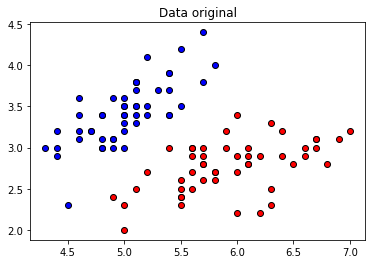

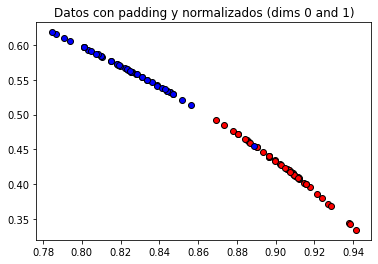

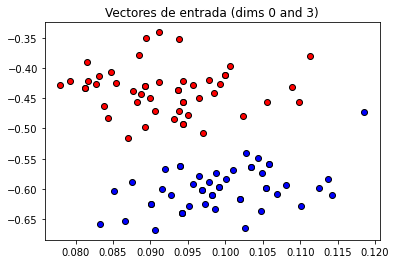

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="b", marker="o", edgecolors="k")
plt.title("Data original")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="b", marker="o", edgecolors="k")
plt.title("Datos con padding y normalizados (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="b", marker="o", edgecolors="k"
)
plt.title("Vectores de entrada (dims {} and {})".format(dim1, dim2))
plt.show()


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# util para graficar los resultados obtenidos
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Vamos a entrenar el modelo

In [0]:
# hiperparametros 
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0) # pesos iniciales

In [0]:
opt = AdamOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9648742 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.9379605 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.9123435 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.8821458 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.8467743 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.8069294 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.7638874 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.7158774 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.6635182 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.6125177 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.5600517 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.5064697 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    13 | Co

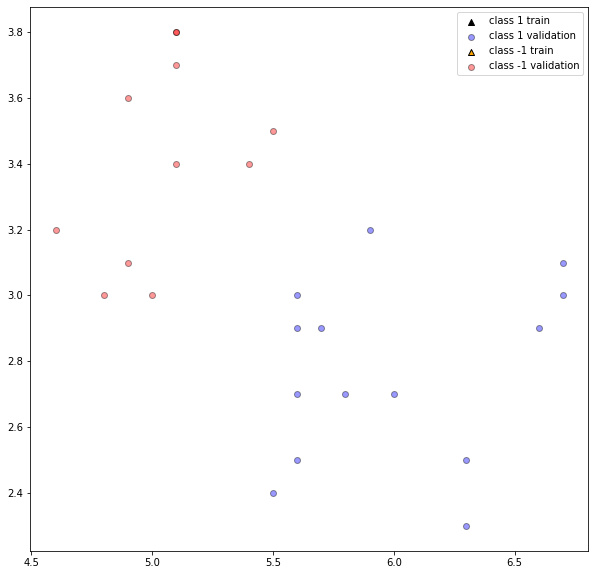

In [0]:
# ploteamos resultados
plt.figure(figsize=(10,10))

# plot data
plt.scatter(
    X_val[:, 0][predictions_val == 1],
    X_val[:, 1][predictions_val == 1],
    c="black",
    marker="^",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val[:, 0][predictions_val == -1],
    X_val[:, 1][predictions_val == -1],
    c="orange",
    marker="^",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

# **Dataset generado artificialmente**

Este dataset lo generamos artificialmente siguiendo el tutorial de pennylane (https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html). Se trata de generar dos clases separadas por un círculo. Es un problema binario y sigue la senda de los datasets tratados hasta ahora.

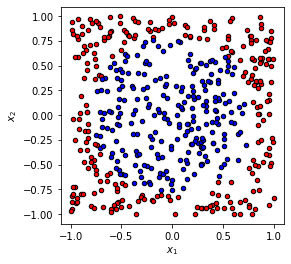

In [0]:
# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = -1
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == -1
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


X_circle, y_circle = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X_circle, y_circle, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

Una vez cargado el dataset, vamos a aplicarle el mismo preprocesamiento que en lso casos anteriores.

In [0]:
print("Primera entrada X (original)  :", X_circle[0])

# pad the vectors to size 2^2 with constant values
padding_circle = 0.3 * np.ones((len(X_circle), 1))
X_pad_circle = np.c_[np.c_[X_circle, padding_circle], np.zeros((len(X_circle), 1))]
print("Primera entrada X (padded)    :", X_pad_circle[0])

# normalize each input
normalization_circle = np.sqrt(np.sum(X_pad_circle ** 2, -1))
X_norm_circle = (X_pad_circle.T / normalization_circle).T
print("Primera entrada X (normalized):", X_norm_circle[0])

# angles for state preparation are new features
features_circle = np.array([get_angles(x) for x in X_norm_circle])
print("Primeros atributos de entrada      :", features_circle[0])

Primera entrada X (original)  : [-0.54583206 -0.09028024]
Primera entrada X (padded)    : [-0.54583206 -0.09028024  0.3         0.        ]
Primera entrada X (normalized): [-0.86729302 -0.14344966  0.47668125  0.        ]
Primeros atributos de entrada      : [ 0.99375112 -0.          0.         -0.16391531  0.16391531]


In [0]:
X_circle.shape, y_circle.shape

((500, 2), (500,))

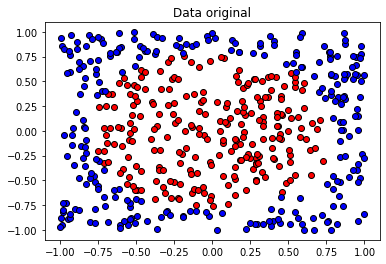

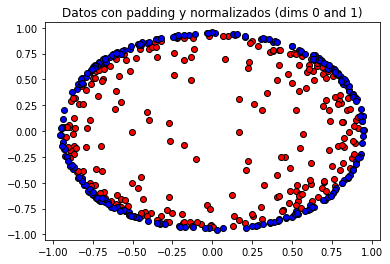

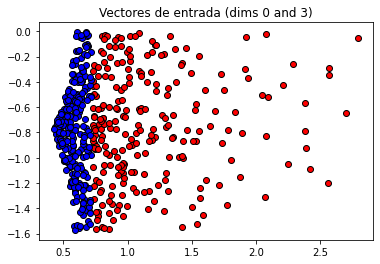

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_circle[:, 0][y_circle == 1], X_circle[:, 1][y_circle == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X_circle[:, 0][y_circle == -1], X_circle[:, 1][y_circle == -1], c="b", marker="o", edgecolors="k")
plt.title("Data original")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm_circle[:, dim1][y_circle == 1], X_norm_circle[:, dim2][y_circle == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X_norm_circle[:, dim1][y_circle == -1], X_norm_circle[:, dim2][y_circle == -1], c="b", marker="o", edgecolors="k")
plt.title("Datos con padding y normalizados (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features_circle[:, dim1][y_circle == 1], features_circle[:, dim2][y_circle == 1], c="r", marker="o", edgecolors="k")
plt.scatter(
    features_circle[:, dim1][y_circle == -1], features_circle[:, dim2][y_circle == -1], c="b", marker="o", edgecolors="k"
)
plt.title("Vectores de entrada (dims {} and {})".format(dim1, dim2))
plt.show()


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data_circle = len(y_circle)
num_train_circle = int(0.75 * num_data_circle)
index_circle = np.random.permutation(range(num_data_circle))
feats_train_circle = features_circle[index_circle[:num_train_circle]]
Y_train_circle = y_circle[index_circle[:num_train_circle]]
feats_val_circle = features_circle[index_circle[num_train_circle:]]
Y_val_circle = y_circle[index_circle[num_train_circle:]]

# util para graficar los resultados obtenidos
X_train_cirle = X_circle[index_circle[:num_train_circle]]
X_val_circle = X_circle[index_circle[num_train_circle:]]

In [0]:
# hiperparametros 
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0) # pesos iniciales

In [0]:
opt = AdamOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(150):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train_circle, (batch_size,))
    feats_train_batch = feats_train_circle[batch_index]
    Y_train_batch = Y_train_circle[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train_circle]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val_circle]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train_circle, predictions_train)
    acc_val = accuracy(Y_val_circle, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features_circle, y_circle), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9591311 | Acc train: 0.3866667 | Acc validation: 0.4240000 
Iter:     2 | Cost: 1.9312674 | Acc train: 0.3786667 | Acc validation: 0.4240000 
Iter:     3 | Cost: 1.9084305 | Acc train: 0.3760000 | Acc validation: 0.4240000 
Iter:     4 | Cost: 1.8876653 | Acc train: 0.3626667 | Acc validation: 0.4240000 
Iter:     5 | Cost: 1.8694918 | Acc train: 0.3626667 | Acc validation: 0.4080000 
Iter:     6 | Cost: 1.8511434 | Acc train: 0.3546667 | Acc validation: 0.4000000 
Iter:     7 | Cost: 1.8374913 | Acc train: 0.3520000 | Acc validation: 0.4000000 
Iter:     8 | Cost: 1.8249919 | Acc train: 0.3493333 | Acc validation: 0.3840000 
Iter:     9 | Cost: 1.8115853 | Acc train: 0.3413333 | Acc validation: 0.3760000 
Iter:    10 | Cost: 1.7986488 | Acc train: 0.3386667 | Acc validation: 0.3680000 
Iter:    11 | Cost: 1.7858689 | Acc train: 0.3306667 | Acc validation: 0.3680000 
Iter:    12 | Cost: 1.7739269 | Acc train: 0.3306667 | Acc validation: 0.3600000 
Iter:    13 | Co

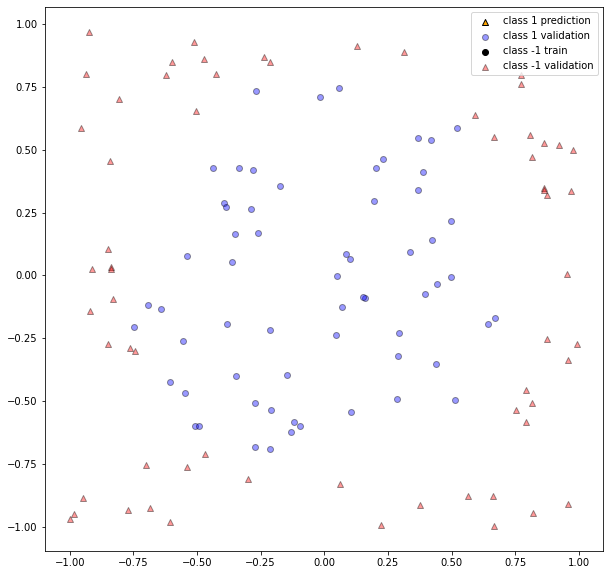

In [0]:
# ploteamos resultados
plt.figure(figsize=(10,10))

# plot data
plt.scatter(
    X_val_circle[:, 0][predictions_val == 1],
    X_val_circle[:, 1][predictions_val == 1],
    c="orange",
    marker="^",
    edgecolors="k",
    label="class 1 prediction",
)
plt.scatter(
    X_val_circle[:, 0][Y_val_circle == 1],
    X_val_circle[:, 1][Y_val_circle == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val_circle[:, 0][predictions_val == -1],
    X_val_circle[:, 1][predictions_val == -1],
    c="black",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val_circle[:, 0][Y_val_circle == -1],
    X_val_circle[:, 1][Y_val_circle == -1],
    c="r",
    marker="^",
    alpha = .4,
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

# **Dataset Artificial generado con Scikit learn**

In [0]:
from sklearn.datasets import make_blobs
X_blob, y = make_blobs(n_samples=400, centers=2, n_features=2, random_state=42)

In [0]:
y_blob = []
for tar in y:

  if tar == 1:
    y_blob.append(1)
  else:
    y_blob.append(-1)

In [0]:
y_blob = np.asarray(y_blob)

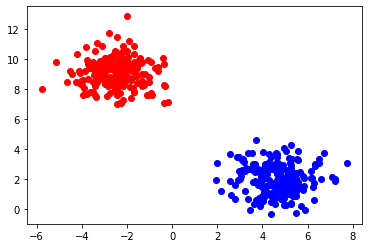

In [0]:
plt.scatter(X_blob[:,0][y_blob == -1],X_blob[:,1][y_blob == -1],c='r')
plt.scatter(X_blob[:,0][y_blob == 1],X_blob[:,1][y_blob == 1], c='b')

Lo graficamos y aplicamos el preprocesamiento aplicado hasta ahora


In [0]:
print("Primera entrada X (original)  :", X_blob[0])

# pad the vectors to size 2^2 with constant values
padding_blob = 0.1 * np.ones((len(X_blob), 1))
X_pad_blob = np.c_[np.c_[X_blob, padding_blob], np.zeros((len(X_blob), 1))]
print("Primera entrada X (padded)    :", X_pad_blob[0])

# normalize each input
normalization_blob = np.sqrt(np.sum(X_pad_blob ** 2, -1))
X_norm_blob = (X_pad_blob.T / normalization_blob).T
print("Primera entrada X (normalized):", X_norm_blob[0])

# angles for state preparation are new features
features_blob = np.array([get_angles(x) for x in X_norm_blob])
print("Primeros atributos de entrada      :", features_blob[0])

Primera entrada X (original)  : [5.64617165 1.39627781]
Primera entrada X (padded)    : [5.64617165 1.39627781 0.1        0.        ]
Primera entrada X (normalized): [0.97061345 0.24002919 0.01719065 0.        ]
Primeros atributos de entrada      : [ 0.03438299 -0.          0.         -0.24243247  0.24243247]


Graficamos los datos sin transformar y luego de las transformacion hecha

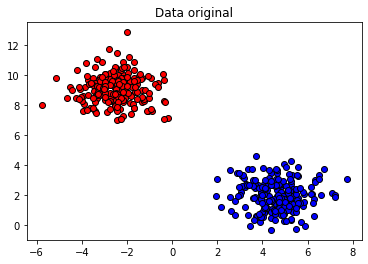

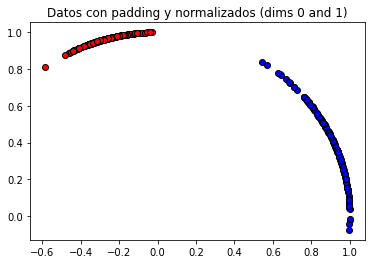

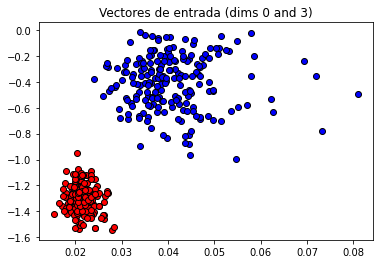

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_blob[:, 0][y_blob == -1], X_blob[:, 1][y_blob == -1], c="r", marker="o", edgecolors="k")
plt.scatter(X_blob[:, 0][y_blob == 1], X_blob[:, 1][y_blob == 1], c="b", marker="o", edgecolors="k")
plt.title("Data original")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm_blob[:, dim1][y_blob == -1], X_norm_blob[:, dim2][y_blob == -1], c="r", marker="o", edgecolors="k")
plt.scatter(X_norm_blob[:, dim1][y_blob == 1], X_norm_blob[:, dim2][y_blob == 1], c="b", marker="o", edgecolors="k")
plt.title("Datos con padding y normalizados (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features_blob[:, dim1][y_blob == -1], features_blob[:, dim2][y_blob == -1], c="r", marker="o", edgecolors="k")
plt.scatter(
    features_blob[:, dim1][y_blob == 1], features_blob[:, dim2][y_blob == 1], c="b", marker="o", edgecolors="k"
)
plt.title("Vectores de entrada (dims {} and {})".format(dim1, dim2))
plt.show()


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data_blob = len(y_blob)
num_train_blob = int(0.75 * num_data_blob)
index_blob = np.random.permutation(range(num_data_blob))
feats_train_blob = features_blob[index_blob[:num_train_blob]]
Y_train_blob = y_blob[index_blob[:num_train_blob]]
feats_val_blob = features_blob[index_blob[num_train_blob:]]
Y_val_blob = y_blob[index_blob[num_train_blob:]]

# util para graficar los resultados obtenidos
X_train_blob = X_blob[index_blob[:num_train_blob]]
X_val_blob = X_blob[index_blob[num_train_blob:]]

In [0]:
# hiperparametros 
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0) # pesos iniciales

In [0]:
opt = AdamOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(50):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train_blob, (batch_size,))
    feats_train_batch = feats_train_blob[batch_index]
    Y_train_batch = Y_train_blob[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train_blob]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val_blob]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train_blob, predictions_train)
    acc_val = accuracy(Y_val_blob, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features_blob, y_blob), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9722159 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     2 | Cost: 1.9506191 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     3 | Cost: 1.9290244 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     4 | Cost: 1.9081556 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     5 | Cost: 1.8854558 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     6 | Cost: 1.8623663 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     7 | Cost: 1.8346573 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     8 | Cost: 1.8027723 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:     9 | Cost: 1.7675843 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:    10 | Cost: 1.7311487 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:    11 | Cost: 1.6896352 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:    12 | Cost: 1.6432768 | Acc train: 0.4833333 | Acc validation: 0.5500000 
Iter:    13 | Co

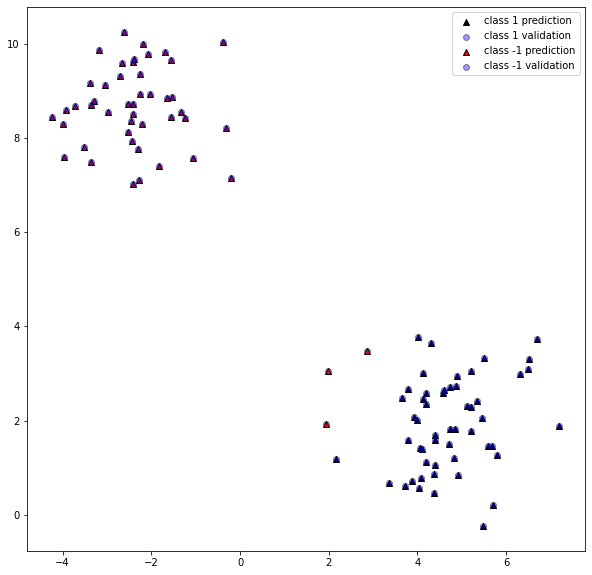

In [0]:
# # ploteamos resultados
plt.figure(figsize=(10,10))

predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val_blob]
predictions_val = np.asarray(predictions_val)

# plot data
plt.scatter(
    X_val_blob[:, 0][predictions_val == 1],
    X_val_blob[:, 1][predictions_val == 1],
    c="black",
    marker="^",
    edgecolors="k",
    label="class 1 prediction",
)
plt.scatter(
    X_val_blob[:, 0][Y_val_blob == 1],
    X_val_blob[:, 1][Y_val_blob == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val_blob[:, 0][predictions_val == -1],
    X_val_blob[:, 1][predictions_val == -1],
    c="red",
    marker="^",
    edgecolors="k",
    label="class -1 prediction",
)
plt.scatter(
    X_val_blob[:, 0][Y_val_blob == -1],
    X_val_blob[:, 1][Y_val_blob == -1],
    c="b",
    marker="o",
    alpha = 0.4,
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()